In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

%matplotlib inline

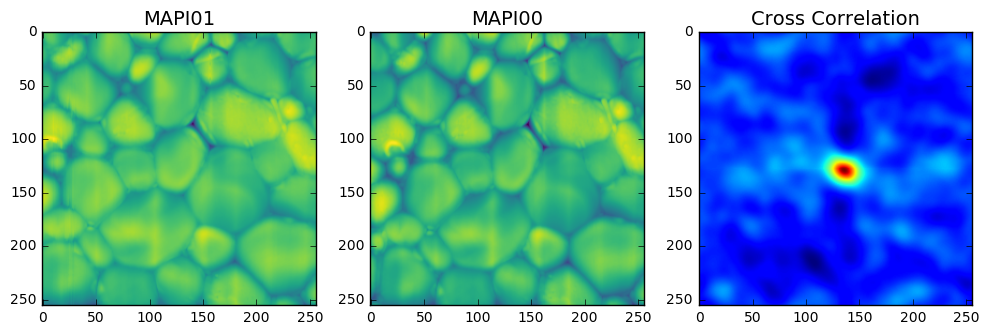

Detected pixel offset (y, x): [ 1.  7.]


In [17]:
MAPI01HeightPath='../data/MAPI_01.txt'
MAPI00HeightPath='../data/MAPI_00.txt'
#load in txt files corresponding to height
MAPI01Height=np.loadtxt(MAPI01HeightPath, delimiter="\t", dtype='float')
MAPI00Height=np.loadtxt(MAPI00HeightPath, delimiter="\t", dtype='float')
ImageProduct=np.fft.fft2(MAPI00Height)*np.fft.fft2(MAPI01Height).conj()
CrossCorrelation=np.fft.fftshift(np.fft.ifft2(ImageProduct))

fig=plt.figure(figsize=(12,10))

MAPI01_plt=fig.add_subplot(131)
MAPI00_plt=fig.add_subplot(132)
CrossCorrelation_plt=fig.add_subplot(133)

MAPI01_plt.set_title('MAPI01', fontsize=14)
MAPI00_plt.set_title('MAPI00', fontsize=14)
#what does this cross correlation show? what does the dark spot correspond to? 
CrossCorrelation_plt.set_title('Cross Correlation', fontsize=14)

MAPI01_plt.imshow(MAPI01Height,cmap='viridis')
MAPI00_plt.imshow(MAPI00Height,cmap='viridis')
CrossCorrelation_plt.imshow(CrossCorrelation.real)
plt.show()

#01 is offset from 00 
shift,error,diffphase=register_translation(MAPI00Height, MAPI01Height)
print("Detected pixel offset (y, x): {}".format(shift))

#5x5 um images of roughly the same area
#256x256 image 

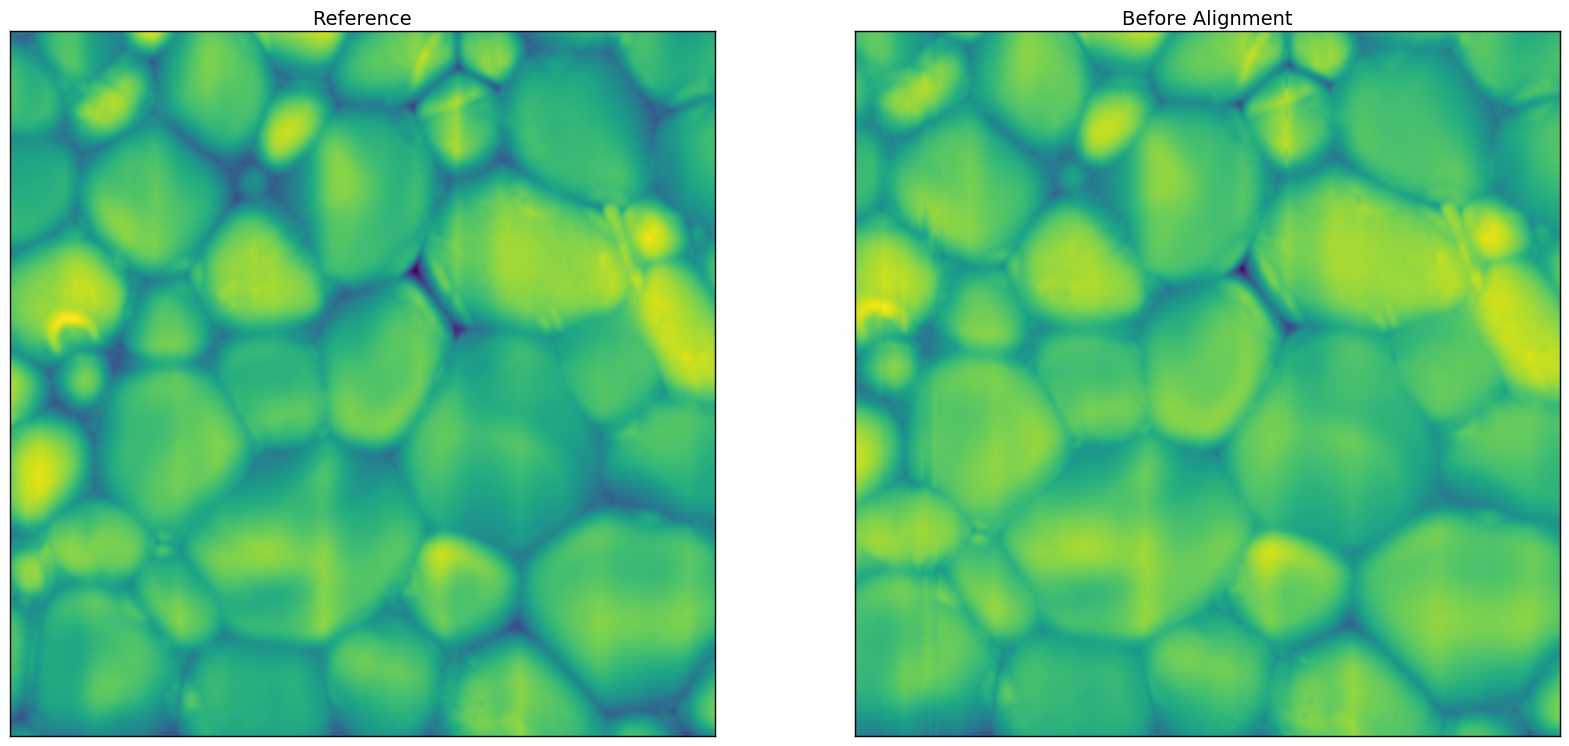

(249, 255)

In [38]:
#offset the image to match 00: 
MAPI01HeightRolled=np.roll(MAPI01Height,(1,7), axis=(1,0))

#also try slicing, but not sure if i am slicing the correct region.
MAPI01HeightSlice=MAPI01Height[7:,1:]

#display with offset and sliced image
fig=plt.figure(figsize=(20,10))

MAPI01_plt=fig.add_subplot(122)
MAPI00_plt=fig.add_subplot(121)
#MAPI01HeightRolled_plt=fig.add_subplot(143)
#MAPI01HeightSlice_plt=fig.add_subplot(144)


MAPI01_plt.set_title('Before Alignment', fontsize=14)
MAPI00_plt.set_title('Reference', fontsize=14)
#what does this cross correlation show? what does the dark spot correspond to? 
#MAPI01HeightRolled_plt.set_title('MAPI01 Rolled', fontsize=14)
#MAPI01HeightSlice_plt.set_title('MAPI01 Slice', fontsize=14)




MAPI01_plt.imshow(MAPI01Height,cmap='viridis')
MAPI01_plt.axes.get_xaxis().set_visible(False)
MAPI01_plt.axes.get_yaxis().set_visible(False)

MAPI00_plt.imshow(MAPI00Height,cmap='viridis')
MAPI00_plt.axes.get_xaxis().set_visible(False)
MAPI00_plt.axes.get_yaxis().set_visible(False)
#MAPI01HeightRolled_plt.imshow(MAPI01HeightRolled, cmap='viridis')
#MAPI01HeightSlice_plt.imshow(MAPI01HeightSlice, cmap='viridis')
plt.show()


MAPI01HeightSlice.shape

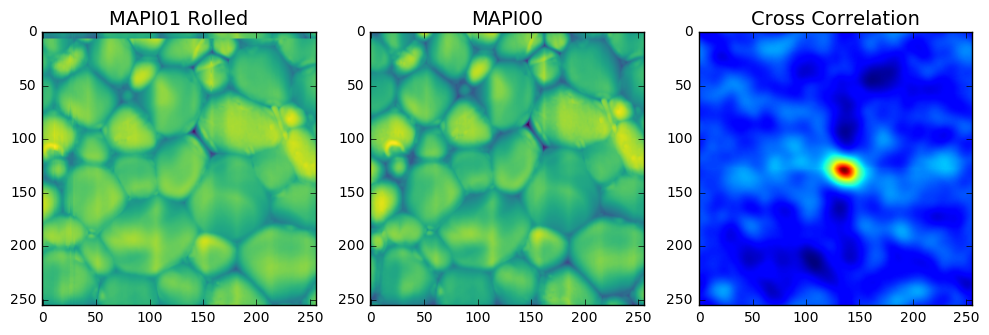

Detected pixel offset (y, x): [-6.  6.]


In [19]:
ImageProduct2=np.fft.fft2(MAPI00Height)*np.fft.fft2(MAPI01HeightRolled).conj()
CrossCorrelation2=np.fft.fftshift(np.fft.ifft2(ImageProduct))


fig=plt.figure(figsize=(12,10))

MAPI01Rolled_plt=fig.add_subplot(131)
MAPI00_plt=fig.add_subplot(132)
CrossCorrelation_plt2=fig.add_subplot(133)


MAPI01Rolled_plt.set_title('MAPI01 Rolled', fontsize=14)
MAPI00_plt.set_title('MAPI00', fontsize=14) 
CrossCorrelation_plt2.set_title('Cross Correlation', fontsize=14)

MAPI01Rolled_plt.imshow(MAPI01HeightRolled,cmap='viridis')
MAPI00_plt.imshow(MAPI00Height,cmap='viridis')
CrossCorrelation_plt2.imshow(CrossCorrelation2.real)
plt.show()

shift,error,diffphase=register_translation(MAPI00Height, MAPI01HeightRolled)
print("Detected pixel offset (y, x): {}".format(shift))
#hmm, expect to be 0 , but it's not cropped so maybe that's why. 

In [20]:
# conda install dipy -c conda-forge

import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
from dipy.align.transforms import (TranslationTransform2D,
                                   RigidTransform2D,
                                   AffineTransform2D)

In [21]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

level_iters = [10000, 1000, 100]

sigmas = [3.0, 1.0, 0.0]

factors = [4, 2, 1]

affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

In [22]:
transform = AffineTransform2D()
params0 = None
static=MAPI00Height
moving=MAPI01Height
affine = affreg.optimize(static, moving, transform, params0)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [23]:
transformed=affine.transform(moving)

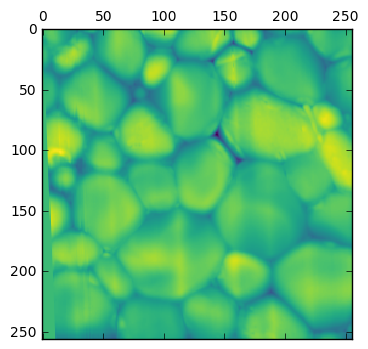

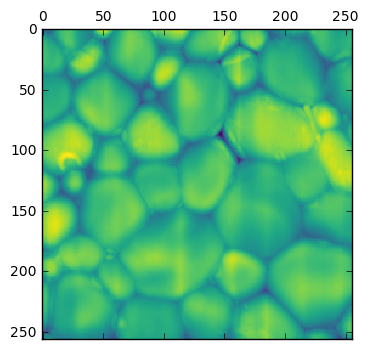

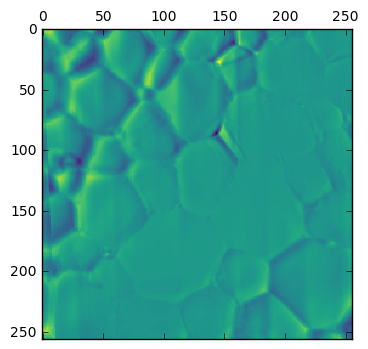

In [24]:
plt.matshow(transformed, cmap='viridis')
plt.matshow(static,cmap='viridis')

plt.matshow(transformed-static, cmap='viridis')

In [25]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
from dipy.viz import regtools

In [26]:
#take center 128x128
#static=MAPI00Height128=np.copy(MAPI00Height[63:191,63:191])
#moving=MAPI01Height128=np.copy(MAPI01Height[63:191,63:191])

static=MAPI00Height
moving=MAPI01Height

In [27]:
dim = static.ndim
metric = CCMetric(dim)


In [28]:
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

In [29]:
mapping = sdr.optimize(static, moving)

Creating scale space from the moving image. Levels: 4. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 4. Sigma factor: 0.200000.
Optimizing level 3
Optimizing level 2
Optimizing level 1
Optimizing level 0


(array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  112.66108704,  115.09909821, ...,  118.0107193 ,
          121.58937073,  127.        ],
        [   0.        ,  111.15377045,  127.        , ...,  127.        ,
          127.        ,  127.        ],
        ..., 
        [   0.        ,  121.48986816,  127.        , ...,  126.99999237,
          127.        ,  127.        ],
        [   0.        ,  125.48149109,  127.00000763, ...,  127.        ,
          127.        ,  127.        ],
        [   0.        ,  127.        ,  127.        , ...,  127.        ,
          127.        ,  127.        ]], dtype=float32),
 array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  127.        ,  127.00000763, ...,  127.        ,
          127.        ,  127.        ],
        [   0.        ,  127.        ,  127.        , ...

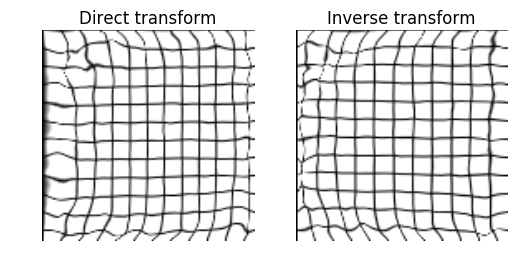

In [131]:
regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

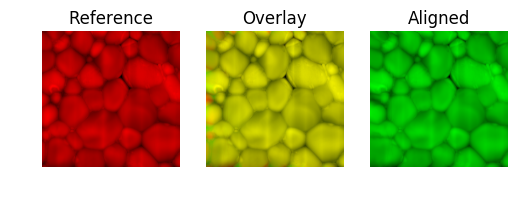

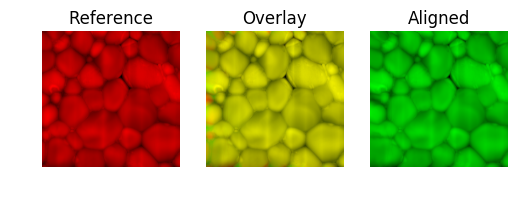

In [36]:
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(static, warped_moving, 'Reference','Overlay','Aligned',
   'direct_warp_result.png')

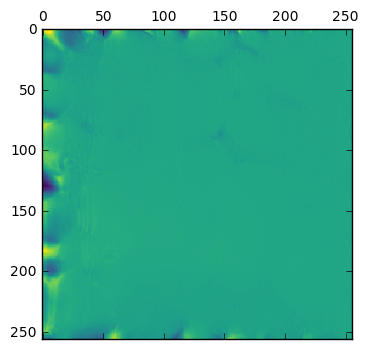

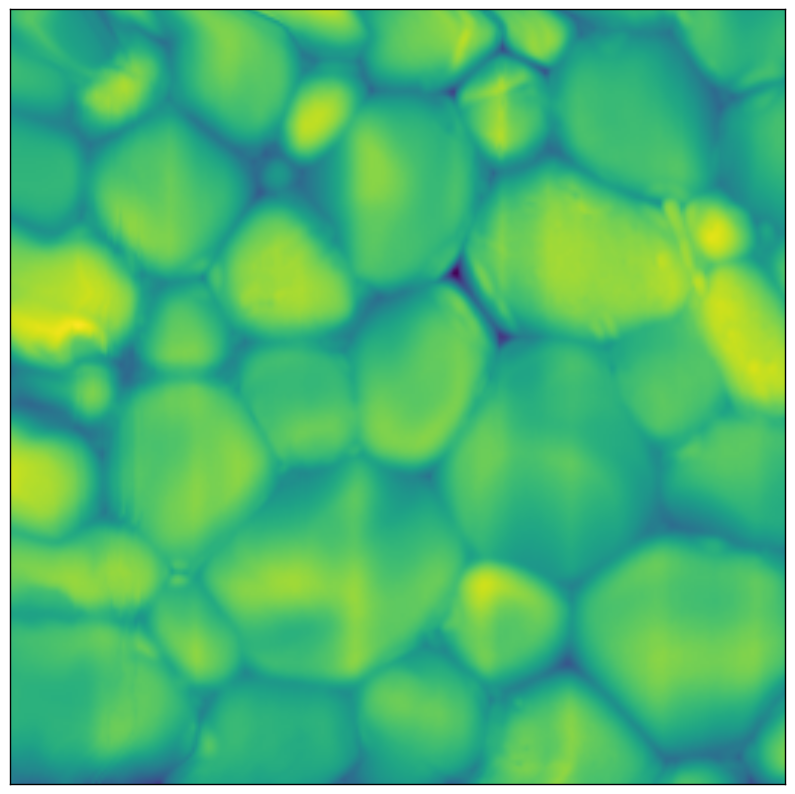

In [42]:
plt.matshow(warped_moving-static, cmap='viridis')

fig=plt.figure(figsize=(12,10))

#Error_plt=fig.add_subplot(121)
Transformed_plt=fig.add_subplot(111)


#Error_plt.imshow(warped_moving-static,cmap='viridis')
#Error_plt.axes.get_xaxis().set_visible(False)
#Error_plt.axes.get_yaxis().set_visible(False)
Transformed_plt.imshow(warped_moving, cmap='viridis')
Transformed_plt.axes.get_xaxis().set_visible(False)
Transformed_plt.axes.get_yaxis().set_visible(False)

plt.show()


In [ ]:
mapping.forward(MAPI)

In [ ]:
plt.matshow(mapping.forward[:, :, 0], cmap='viridis')
plt.matshow(mapping.forward[:, :, 1], cmap='viridis')